### Classifiers

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator


spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.read.csv("KO.csv", header=True, inferSchema=True) 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/04 18:24:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Buy or Sell
https://www.investopedia.com/articles/technical/073001.asp

Using the stochastics %D line formula:
$D= 100 \bigg (\frac{H3}{L3} \bigg)$ 

Where, H3 is the Highest of the three previous stock prices and L3 is the lowest price in the same three day period.

In [2]:
df.take(1)

[Row(Date=datetime.date(1962, 1, 2), Open=0.263021, High=0.270182, Low=0.263021, Close=0.263021, Adj Close=0.048528, Volume=806400)]

In [3]:
windowSpec = Window().orderBy("Date")

# Calculate H3 and L3 using the window functions
df = df.withColumn("H3", F.max("Adj Close").over(windowSpec.rowsBetween(-2, 0)))
df = df.withColumn("L3", F.min("Adj Close").over(windowSpec.rowsBetween(-2, 0)))

# Calculate the D line
df = df.withColumn("D", 100 * (F.col("H3") / F.col("L3")))

# Create a binary class column based on the D line buy = 0, sell = 1
df = df.withColumn("Class", F.when(F.col("D") > 102, 1).otherwise(0))

# Show the resulting DataFrame
df.show(10)

23/12/04 18:24:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+--------+--------+--------+--------+---------+-------+--------+--------+------------------+-----+
|      Date|    Open|    High|     Low|   Close|Adj Close| Volume|      H3|      L3|                 D|Class|
+----------+--------+--------+--------+--------+---------+-------+--------+--------+------------------+-----+
|1962-01-02|0.263021|0.270182|0.263021|0.263021| 0.048528| 806400|0.048528|0.048528|             100.0|    0|
|1962-01-03|0.259115|0.259115|0.253255|0.257161| 0.047447|1574400|0.048528|0.047447|102.27833161211457|    1|
|1962-01-04|0.257813|0.261068|0.257813|0.259115| 0.047807| 844800|0.048528|0.047447|102.27833161211457|    1|
|1962-01-05|0.259115| 0.26237|0.252604|0.253255| 0.046726|1420800|0.047807|0.046726|102.31348713778196|    1|
|1962-01-08|0.251302|0.251302|0.245768|0.250651| 0.046246|2035200|0.047807|0.046246|103.37542706396228|    1|
|1962-01-09|0.250651| 0.25651|0.248698|0.255208| 0.047087| 960000|0.047087|0.046246| 101.8185356571379|    0|
|1962-01-1

### Naive Bayes

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
from pyspark.ml.feature import StandardScaler


# Drop unnecessary columns
nb_df = df.drop("Date", "label", "D")

outcome = "Class"

# Compile all columns that are not the outcome
feature_cols = [col for col in nb_df.columns if col not in [outcome, "label"]]

# Convert the "Class" column to a numeric type using StringIndexer
indexer = StringIndexer(inputCol=outcome, outputCol="label")
nb_df = indexer.fit(nb_df).transform(nb_df)

# Create a vector assembler
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="nb_features")

# Transform the DataFrame using the vector assembler
nb_assembled = vector_assembler.transform(nb_df)

scaler = StandardScaler(inputCol="nb_features", outputCol="scaledFeatures")
scalerModel = scaler.fit(nb_assembled)
scaledData = scalerModel.transform(nb_assembled)

# Split the data into training and testing sets
train_data, test_data = scaledData.randomSplit([0.8, 0.2], seed=42)

# Calculate class weights based on the class distribution
class_counts = train_data.groupBy("label").count()
total_count = train_data.count()

# Calculate class weights based on the class distribution
train_data = train_data.join(class_counts.withColumn("classWeight", F.col("count") / total_count), "label")

# Create a Naive Bayes model
naive_bayes = NaiveBayes(featuresCol="scaledFeatures", labelCol="label", smoothing=0.001, weightCol="classWeight")

# Train the model
naive_bayes_model = naive_bayes.fit(train_data)

# Make predictions on the test set
predictions = naive_bayes_model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)

# Print the area under ROC
print(f"Area under ROC: {area_under_roc}")
predictions.select("label", "prediction").show()


23/12/04 18:24:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 1

Area under ROC: 0.532300606251477
+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  1.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



23/12/04 18:24:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [5]:
predictions.show(2)

23/12/04 18:24:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------+--------+--------+--------+---------+-------+--------+--------+-----+-----+--------------------+--------------------+--------------------+--------------------+----------+
|    Open|    High|     Low|   Close|Adj Close| Volume|      H3|      L3|Class|label|         nb_features|      scaledFeatures|       rawPrediction|         probability|prediction|
+--------+--------+--------+--------+---------+-------+--------+--------+-----+-----+--------------------+--------------------+--------------------+--------------------+----------+
| 0.19401|0.199219|0.193359|0.199219| 0.037532|2035200|0.037716| 0.03655|    1|  1.0|[0.19401,0.199219...|[0.01054456195890...|[-0.7771428325852...|[0.82887773679771...|       0.0|
|0.199219|0.199219|0.195964|0.197591| 0.037225| 537600|0.037532|0.037225|    0|  0.0|[0.199219,0.19921...|[0.01082767428942...|[-0.4055794156242...|[0.84081138124395...|       0.0|
+--------+--------+--------+--------+---------+-------+--------+--------+-----+-----+----------

23/12/04 18:24:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 18:24:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


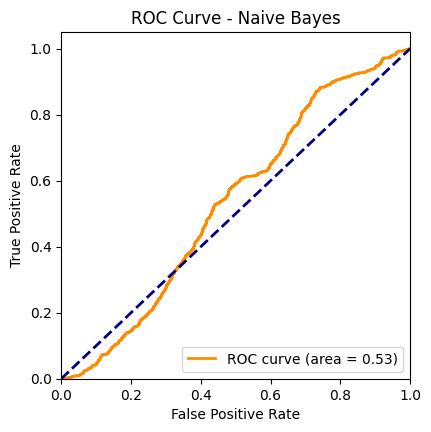

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Convert PySpark DataFrame to Pandas DataFrame
predictions_pd = predictions.select("label", "rawPrediction").toPandas()

# Get the probability column from predictions_pd
probs = np.array(predictions_pd[["label", "rawPrediction"]].apply(lambda row: (float(row['rawPrediction'][1]), float(row['label'])), axis=1).tolist())


# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(probs[:,1], probs[:,0])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4.5, 4.5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

In [7]:
from pyspark.ml.classification import LinearSVC

svm_df = spark.read.csv("KO_class.csv", header=True, inferSchema=True) 
# Drop unnecessary columns
svm_df = svm_df.drop("label","Date", "D")


# Define outcome and feature columns
outcome = "Class"
feature_cols = [col for col in svm_df.columns if col not in outcome]

# Vector assembler for feature transformation
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="svm_features")
svm_assembled = vector_assembler.transform(svm_df)

# Transform the DataFrame using the vector assembler
nb_assembled = vector_assembler.transform(nb_df)

scaler = StandardScaler(inputCol="svm_features", outputCol="scaledFeatures")
scalerModel = scaler.fit(svm_assembled)
scaledData = scalerModel.transform(svm_assembled)

# Split the data into training and testing sets
train_data, test_data = scaledData.randomSplit([0.8, 0.2], seed=42)

# Linear SVM model
svm_classifier = LinearSVC(featuresCol="svm_features", labelCol="Class", maxIter=10)
svm_model = svm_classifier.fit(train_data)

# Make predictions on the test set
svm_predictions = svm_model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
SVM_evaluator = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
area_under_roc = SVM_evaluator.evaluate(svm_predictions)

# Print the area under ROC
print(f"Area under ROC: {area_under_roc}")
svm_predictions.select("Class", "prediction").show()

Area under ROC: 0.6495157861585711
+-----+----------+
|Class|prediction|
+-----+----------+
|    1|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 20 rows



23/12/04 18:24:28 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


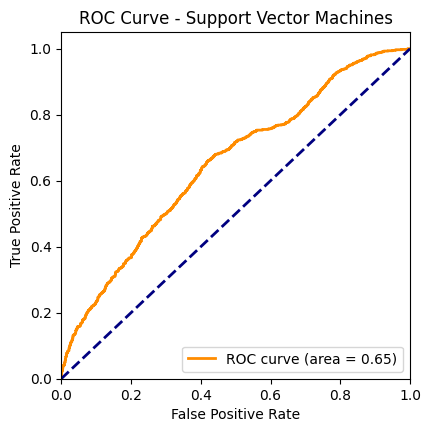

In [8]:
# Convert PySpark DataFrame to Pandas DataFrame
svm_predictions_pd = svm_predictions.select("Class", "rawPrediction").toPandas()

# Extract probability and class columns
svm_probs = np.array(svm_predictions_pd[["Class", "rawPrediction"]].apply(lambda row: (float(row['rawPrediction'][1]), float(row['Class'])), axis=1).tolist())

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(svm_probs[:,1], svm_probs[:,0])  # Use svm_probs consistently
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(4.5, 4.5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Machines')
plt.legend(loc="lower right")
plt.show()